<a href="https://colab.research.google.com/github/Dienert/reviews_analyzer/blob/main/notebooks/5%20-%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

https://github.com/dipanjanS/nlp_workshop_odsc_europe20/blob/master/notebooks/Module_03_NLP%20Applications%20-%20Machine%20and%20Deep%20Learning/13_NLP_Applications_Text_Classification_Deep_Learning_Sequential_Models_LSTMs.ipynb

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [127]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

Put the hyparameters at the top like this to make it easier to change and edit.

In [4]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

First, let's define two lists that containing articles and labels. In the meantime, we remove stopwords.

In [7]:
!curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/train.csv > train.csv
!curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/val.csv > val.csv
!curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/test.csv > test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  946k  100  946k    0     0  2967k      0 --:--:-- --:--:-- --:--:-- 2958k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  138k  100  138k    0     0   422k      0 --:--:-- --:--:-- --:--:--  422k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150k  100  150k    0     0   478k      0 --:--:-- --:--:-- --:--:--  476k


In [8]:
import pandas as pd

In [10]:
train = pd.read_csv('train.csv')
train

,x,y
0,Four Stars. thought provoking,1
1,Not What I Expected. Although a few of the sto...,0
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Surprisingly good..... .. Interesting connecti...,1
4,Success. Good book to read for success,2
...,...,...
3420,Thoughts on Gladwell's Outliers: An exceptiona...,2
3421,Spellbinding. I haven't read other Gladwell bo...,2
3422,Very Thought Provoking. Excellent book. This b...,2
3423,Very Interesting and Well Done. This book help...,1


In [26]:
train.y.value_counts()

2    1520
1    1231
0     674
Name: y, dtype: int64

In [29]:
train_sentiments = train.y.map({0: 'negative', 1:'negative', 2:'positive'})

In [30]:
train_sentiments.value_counts()

negative    1905
positive    1520
Name: y, dtype: int64

In [31]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
x_resampled, y_resampled = rus.fit_resample(train.x.values.reshape(-1,1), train_sentiments)

In [32]:
x_resampled.shape

(3040, 1)

In [58]:
train_articles = pd.Series(x_resampled.reshape(-1,))
train_articles

0       Great Read. Would recommend.. Similar writing ...
1       Very interestings concepts. The ideas were ver...
2       All In Education Should Read This. This book s...
3       Worthy Read: Gladwell's Intent. No, it [excell...
4       Pretty good read.. Overall this is a pretty go...
                              ...                        
3035    Insightful, knowledgable and fun.. Brilliant b...
3036    Thoughts on Gladwell's Outliers: An exceptiona...
3037    Spellbinding. I haven't read other Gladwell bo...
3038    Very Thought Provoking. Excellent book. This b...
3039    Seeing the forest instead of the trees. Life i...
Length: 3040, dtype: object

In [59]:
train_labels = pd.Series(y_resampled)

In [60]:
train_labels.value_counts()

negative    1520
positive    1520
Name: y, dtype: int64

In [61]:
train_labels = train_labels.values

In [63]:
val = pd.read_csv("val.csv")
val

,x,y
0,Enlighting!. Very interesting book. It makes y...,1
1,Thoroughly enjoyed!. a highly relevant and wel...,2
2,a must read!. great book a must read!,2
3,Okay for a Used Book. It looks okay for a used...,0
4,Great service and Great book. Great arrival ti...,2
...,...,...
537,"Well written. The author, Malcolm Gladwell, pr...",2
538,Causes one to stop and think. Really an intere...,1
539,Very Interesting. Gladwell does looks at thing...,2
540,Wonderful. Bought this following a recommendat...,2


In [64]:
validation_articles = val.x
validation_labels = val.y.map({0: 'negative', 1:'negative', 2:'positive'})
validation_labels.value_counts()

negative    302
positive    240
Name: y, dtype: int64

In [65]:
validation_labels = validation_labels.values

In [ ]:
test = pd.read_csv("test.csv")
test

,x,y
0,A great read and worth every penny!. My first ...,2
1,"Senior English. Dear Mr. Gladwell,  am a seni...",1
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Five Stars. I like Malcolm Gladwell books.,2
4,A Different Perspective on the Nature of Succe...,2
...,...,...
537,Worth the money. page quality is good but its ...,1
538,Absolute Genius. This is the first book I read...,2
539,Excellent book. Outliers is an intriguing book...,2
540,Another article turned into a book. This is ye...,0


In [66]:
test_articles = test.x
test_labels = test.y.map({0: 'negative', 1:'negative', 2:'positive'})
test_labels.value_counts()

negative    302
positive    240
Name: y, dtype: int64

In [67]:
test_labels = test_labels.values

Tokenizer does all the heavy lifting for us. In our articles that it was tokenizing, it will take 5,000 most common words. oov_token is to put a special value in when an unseen word is encountered. This means I want "OOV" in bracket to be used to for words that are not in the word index. "fit_on_text" will go through all the text and create dictionary like this:

In [68]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

You can see that "OOV" in bracket is number 1, "said" is number 2, "mr" is number 3, and so on.

In [69]:
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'a': 5,
 'and': 3,
 'book': 7,
 'i': 8,
 'is': 10,
 'it': 9,
 'of': 6,
 'the': 2,
 'to': 4}

This process cleans up our text, lowercase, and remove punctuations.

After tokenization, the next step is to turn thoes tokens into lists of sequence.

In [70]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

This is the 11th article in the training data that has been turned into sequences.

In [71]:
print(train_sequences[10])

[41, 28, 22, 56, 644, 1182, 11, 2, 430, 131, 29, 1466, 7, 50, 103]


When we train neural networks for NLP, we need sequences to be in the same size, that's why we use padding. Our max_length is 200, so we use pad_sequences to make all of our articles the same length which is 200 in my example. That's why you see that the 1st article was 426 in length, becomes 200, the 2nd article was 192 in length, becomes 200, and so on.

In [72]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [73]:
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

17
200
19
200
15
200


In addtion, there is padding type and truncating type, there are all "post". Means for example, for the 11th article, it was 186 in length, we padded to 200, and we padded at the end, add 14 zeros.

In [74]:
print(train_sequences[10])

[41, 28, 22, 56, 644, 1182, 11, 2, 430, 131, 29, 1466, 7, 50, 103]


In [75]:
print(train_padded[10])

[  41   28   22   56  644 1182   11    2  430  131   29 1466    7   50
  103    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

And for the 1st article, it was 426 in length, we truncated to 200, and we truncated at the end.

In [76]:
print(train_sequences[0])

[23, 14, 79, 95, 600, 185, 4, 31, 90, 501, 210, 52, 115, 2, 72, 39, 888]


In [77]:
print(train_padded[0])

[ 23  14  79  95 600 185   4  31  90 501 210  52 115   2  72  39 888   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


Then we do the same for the validation sequences. Note that we should expect more out of vocabulary words from validation articles because word index were derived from the training articles.

In [78]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

542
(542, 200)


Now we are going to look at the labels. because our labels are text, so we will tokenize them, when training, labels are expected to be numpy arrays. So we will turn list of labels into numpy arrays like so:

In [80]:
labels = ['negative', 'positive']

In [81]:
print(set(labels))

{'negative', 'positive'}


In [82]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [144]:
pd.Series(training_label_seq.reshape(-1,)).value_counts()

1    1520
2    1520
dtype: int64

In [84]:
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[1]
[1]
[1]
(3040, 1)
[1]
[2]
[2]
(542, 1)


Before training deep neural network, we want to explore what our original article and article after padding look like. Running the following code, we explore the 11th article, we can see that some words become "OOV", because they did not make to the top 5,000.

In [85]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

outliers very interesting reading lost air in the last chapter good airplane book well written ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
Outliers. Very interesting reading, lost air in the last chapter. Good airplane book, well written


Now we can implement LSTM. Here is my code that I build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices into sequences of vectors. After training, words with similar meanings often have the similar vectors.

Next is how to implement LSTM in code. The Bidirectional wrapper is used with a LSTM layer, this propagates the input forwards and backwards through the LSTM layer and then concatenates the outputs. This helps LSTM to learn long term dependencies. We then fit it to a dense neural network to do classification.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

In [133]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 394,369
Trainable params: 394,369
Non-trainable params: 0
_________________________________________________________________


In our model summay, we have our embeddings, our Bidirectional contains LSTM, followed by two dense layers. The output from Bidirectional is 128, because it doubled what we put in LSTM. We can also stack LSTM layer but I found the results worse.

In [134]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
95/95 - 45s - loss: -2.6597e+01 - accuracy: 0.4997 - val_loss: -6.0909e+01 - val_accuracy: 0.5572 - 45s/epoch - 473ms/step
Epoch 2/10
95/95 - 9s - loss: -1.3072e+02 - accuracy: 0.5000 - val_loss: -1.8283e+02 - val_accuracy: 0.5572 - 9s/epoch - 96ms/step
Epoch 3/10
95/95 - 9s - loss: -3.0399e+02 - accuracy: 0.5000 - val_loss: -3.7148e+02 - val_accuracy: 0.5572 - 9s/epoch - 99ms/step
Epoch 4/10
95/95 - 9s - loss: -5.5430e+02 - accuracy: 0.5000 - val_loss: -6.2532e+02 - val_accuracy: 0.5572 - 9s/epoch - 100ms/step
Epoch 5/10
95/95 - 9s - loss: -8.8074e+02 - accuracy: 0.5000 - val_loss: -9.4582e+02 - val_accuracy: 0.5572 - 9s/epoch - 99ms/step
Epoch 6/10
95/95 - 9s - loss: -1.2801e+03 - accuracy: 0.5000 - val_loss: -1.3354e+03 - val_accuracy: 0.5572 - 9s/epoch - 99ms/step
Epoch 7/10
95/95 - 9s - loss: -1.7535e+03 - accuracy: 0.5000 - val_loss: -1.7863e+03 - val_accuracy: 0.5572 - 9s/epoch - 99ms/step
Epoch 8/10
95/95 - 9s - loss: -2.2987e+03 - accuracy: 0.5000 - val_loss: -2.299

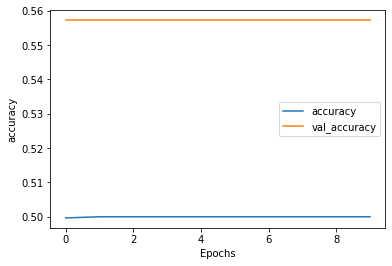

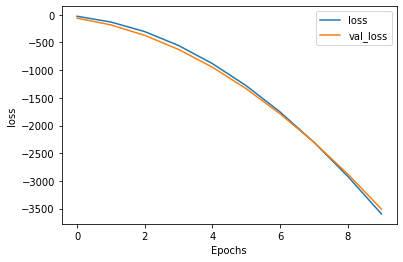

In [136]:
from matplotlib import pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [137]:
txt = test_articles[0]
txt

"A great read and worth every penny!. My first Malcolm Gladwell book and definitely not my last. The book does a great job analyzing talent and success, and the seemingly minor or unnoticed entites that play a large part in determining the disposition of a person. There are a million reviews on this book but I feel it was well written and very entertaining; I found myself not wanting to stop reading! 'Outliers' will be a book that will not just sit and collect dust. This was a great book and great purchase."

In [138]:
text_pipeline = lambda text : pad_sequences(tokenizer.texts_to_sequences(txt), maxlen=max_length)

In [139]:
pd.Series(pred.reshape(-1,)).value_counts()

1.0    511
dtype: int64

In [140]:
pred = model.predict(text_pipeline(txt))
print(pred, labels[np.argmax(pred)])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [141]:
test_articles_padded = pd.Series(test_articles.apply(text_pipeline))

In [142]:
predictions = test_articles_padded.apply(model.predict).ravel()
predictions[:10]

array([array([[1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],
              [1.],


In [ ]:
predictions.ravel()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_labels, predictions))
pd.DataFrame(confusion_matrix(test_labels, predictions), index=labels, columns=labels)